In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
!pip install tensorflow


   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.8/332.0 MB 9.3 MB/s eta 0:00:36
   ---------------------------------------- 3.9/332.0 MB 9.5 MB/s eta 0:00:35
    --------------------------------------- 6.0/332.0 MB 9.5 MB/s eta 0:00:35
    --------------------------------------- 7.3/332.0 MB 9.0 MB/s eta 0:00:37
   - -------------------------------------- 9.2/332.0 MB 8.9 MB/s eta 0:00:37
   - -------------------------------------- 10.2/332.0 MB 8.0 MB/s eta 0:00:41
   - -------------------------------------- 11.8/332.0 MB 7.9 MB/s eta 0:00:41
   - -------------------------------------- 13.9/332.0 MB 8.1 MB/s eta 0:00:40
   - -------------------------------------- 16.0/332.0 MB 8.4 MB/s eta 0:00:38
   -- ------------------------------------- 17.8/332.0 MB 8.4 MB/s eta 0:00:38
   -- ------------------------------------- 18.9/332.0 MB 8.3 MB/s eta 0:00:38
   -- ------------------------------------- 20.2/332.0 MB 8.0 MB/

In [6]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\EXEMPTED\CODED\ML\T1\traffic flow\traffic.csv")

df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')
df.drop('ID', axis=1, inplace=True) # will remove ID column


In [7]:
df['hour'] = df['DateTime'].dt.hour
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int) # tells weekend or not

df.drop('DateTime', axis=1, inplace=True)
df.head()


,Junction,Vehicles,hour,dayofweek,month,is_weekend
0,1,15,0,6,11,1
14592,2,6,0,6,11,1
29184,3,9,0,6,11,1
29185,3,7,1,6,11,1
1,1,13,1,6,11,1


In [8]:
features = ['Junction', 'hour', 'dayofweek', 'month', 'is_weekend', 'Vehicles']
data = df[features]


In [9]:
#scaling data as Neural networks train better when values are between 0 and 1.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_data[:5]

array([[0.        , 0.        , 1.        , 0.90909091, 1.        ,
        0.07821229],
       [0.33333333, 0.        , 1.        , 0.90909091, 1.        ,
        0.02793296],
       [0.66666667, 0.        , 1.        , 0.90909091, 1.        ,
        0.04469274],
       [0.66666667, 0.04347826, 1.        , 0.90909091, 1.        ,
        0.03351955],
       [0.        , 0.04347826, 1.        , 0.90909091, 1.        ,
        0.06703911]])

In [10]:
#creating sequence,, 
def create_sequences(data, time_steps=24): #time frame is 24 hrs
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, -1])  # Vehicles column
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data) # Generate sequences

print("X shape:", X.shape)  # (samples, 24, features)
print("y shape:", y.shape)


X shape: (48096, 24, 6)
y shape: (48096,)


In [11]:
#training and testing split ,, We trained the LSTM model on the first 80% of chronological traffic data and tested it on the remaining 20% future data to simulate real-world forecasting.

split = int(0.8 * len(X)) # 80% data for training
X_train, X_test = X[:split], X[split:]  # Past data for training, future for testing
y_train, y_test = y[:split], y[split:]


In [12]:
# building the lstm model
model = Sequential()  # Create neural network

model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))

# First LSTM layer with 64 memory units
# return_sequences=True → pass full sequence to next LSTM

model.add(LSTM(32))  # Second LSTM layer, compresses sequence into one memory vector
model.add(Dropout(0.2)) # Randomly drop 20% neurons to prevent overfitting

model.add(Dense(1))  # Output layer → predicts 1 value (vehicles)

model.compile(optimizer='adam', loss='mse')  # Adam optimizer adjusts weights, MSE measures error
model.summary()

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#training
history = model.fit(
    X_train, y_train,
    epochs=20,   # Number of full passes over dataset
    batch_size=32,    # Process 32 samples at once
    validation_data=(X_test, y_test)   # Check performance on unseen data
)


Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 64s 48ms/step - loss: 0.0087 - val_loss: 0.0180
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.0075 - val_loss: 0.0172
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0071 - val_loss: 0.0166
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0070 - val_loss: 0.0174
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0069 - val_loss: 0.0159
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0068 - val_loss: 0.0163
Epoch 7/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0067 - val_loss: 0.0159
Epoch 8/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0067 - val_loss: 0.0157
Epoch 9/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0066 - val_loss: 0.0186
Epoch 10/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0066 - val_loss: 0.0155
Epoch 11/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0065 - val_loss: 0.0169
Epoch 12

In [14]:
predictions = model.predict(X_test)


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [15]:
#reverting the scaled data

vehicles_scaler = MinMaxScaler()
vehicles_scaler.fit(data[['Vehicles']])

predictions = vehicles_scaler.inverse_transform(predictions)
y_test_actual = vehicles_scaler.inverse_transform(y_test.reshape(-1,1))


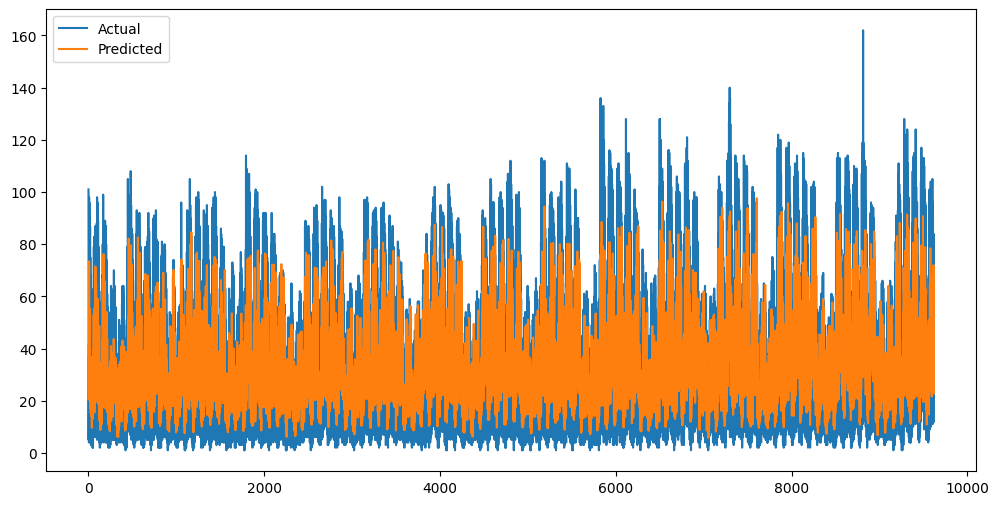

In [16]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.show()


In [18]:
for i in range(20):
    print(f"Actual: {y_test_actual[i][0]:.2f}  |  Predicted: {predictions[i][0]:.2f}")


Actual: 101.00  |  Predicted: 41.29
Actual: 40.00  |  Predicted: 20.68
Actual: 5.00  |  Predicted: 20.42
Actual: 22.00  |  Predicted: 37.61
Actual: 37.00  |  Predicted: 45.65
Actual: 4.00  |  Predicted: 47.72
Actual: 30.00  |  Predicted: 66.56
Actual: 98.00  |  Predicted: 73.45
Actual: 23.00  |  Predicted: 36.45
Actual: 96.00  |  Predicted: 36.35
Actual: 9.00  |  Predicted: 20.94
Actual: 36.00  |  Predicted: 23.46
Actual: 21.00  |  Predicted: 33.53
Actual: 91.00  |  Predicted: 46.47
Actual: 9.00  |  Predicted: 22.90
Actual: 32.00  |  Predicted: 24.50
Actual: 4.00  |  Predicted: 31.67
Actual: 17.00  |  Predicted: 43.00
Actual: 87.00  |  Predicted: 55.05
Actual: 33.00  |  Predicted: 26.31


In [19]:
import os
print(os.getcwd())


C:\Users\ASUS\anaconda_projects\94301781-015f-4013-a501-51e801b7dc54


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# lower MAE and RMSE = better model
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 17.154398850740364
RMSE: 22.225194462359845


In [22]:
# gru model

from tensorflow.keras.layers import GRU

model_gru = Sequential()

model_gru.add(GRU(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(32))
model_gru.add(Dropout(0.2))

model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mse')
model_gru.summary()


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,265 (90.88 KB)

 Trainable params: 23,265 (90.88 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 84s 62ms/step - loss: 0.0088 - val_loss: 0.0177
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - loss: 0.0076 - val_loss: 0.0171
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - loss: 0.0071 - val_loss: 0.0168
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 78s 65ms/step - loss: 0.0070 - val_loss: 0.0170
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step - loss: 0.0068 - val_loss: 0.0158
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 71s 59ms/step - loss: 0.0067 - val_loss: 0.0158
Epoch 7/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0066 - val_loss: 0.0167
Epoch 8/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - loss: 0.0065 - val_loss: 0.0155
Epoch 9/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0065 - val_loss: 0.0154
Epoch 10/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - loss: 0.0064 - val_loss: 0.0157
Epoch 11/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0063 - val_loss: 0.0186
Epoch 12

In [24]:
predictions_gru = model_gru.predict(X_test)
predictions_gru = vehicles_scaler.inverse_transform(predictions_gru)


301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [25]:
mae_gru = mean_absolute_error(y_test_actual, predictions_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual, predictions_gru))

print("GRU MAE:", mae_gru)
print("GRU RMSE:", rmse_gru)

GRU MAE: 17.59472730652373
GRU RMSE: 23.098619732677246


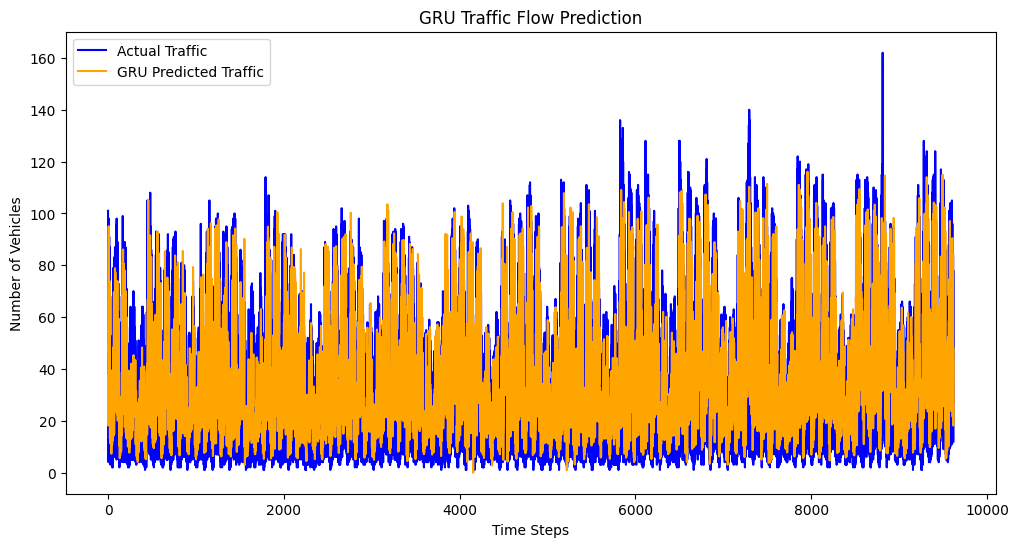

In [26]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Traffic", color='blue')
plt.plot(predictions_gru, label="GRU Predicted Traffic", color='orange')
plt.title("GRU Traffic Flow Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Number of Vehicles")
plt.legend()
plt.show()


In [27]:
for i in range(10):
    print(f"Actual: {y_test_actual[i][0]:.2f} | GRU Predicted: {predictions_gru[i][0]:.2f}")


Actual: 101.00 | GRU Predicted: 37.46
Actual: 40.00 | GRU Predicted: 18.17
Actual: 5.00 | GRU Predicted: 22.19
Actual: 22.00 | GRU Predicted: 37.57
Actual: 37.00 | GRU Predicted: 52.22
Actual: 4.00 | GRU Predicted: 56.54
Actual: 30.00 | GRU Predicted: 80.18
Actual: 98.00 | GRU Predicted: 95.05
Actual: 23.00 | GRU Predicted: 46.53
Actual: 96.00 | GRU Predicted: 47.04


In [28]:

# cnn model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten




In [29]:
model_cnn = Sequential()

model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X.shape[1], X.shape[2])))
# 64 filters look at 3-hour patterns

model_cnn.add(MaxPooling1D(pool_size=2))
# Reduces sequence size → keeps important features

model_cnn.add(Flatten())
# Convert 3D output into 1D vector

model_cnn.add(Dense(50, activation='relu'))
# Learns combination of detected patterns

model_cnn.add(Dense(1))
# Final prediction (vehicles)

model_cnn.compile(optimizer='adam', loss='mse')

model_cnn.summary()


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        35,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,517 (142.64 KB)

 Trainable params: 36,517 (142.64 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0084 - val_loss: 0.0173
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0070 - val_loss: 0.0169
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0068 - val_loss: 0.0173
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0066 - val_loss: 0.0163
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0066 - val_loss: 0.0174
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0065 - val_loss: 0.0168
Epoch 7/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0063 - val_loss: 0.0162
Epoch 8/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0062 - val_loss: 0.0164
Epoch 9/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0062 - val_loss: 0.0161
Epoch 10/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0061 - val_loss: 0.0161
Epoch 11/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0060 - val_loss: 0.0176
Epoch 12/20
1203/

In [31]:
pred_cnn = model_cnn.predict(X_test)
pred_cnn = vehicles_scaler.inverse_transform(pred_cnn)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   


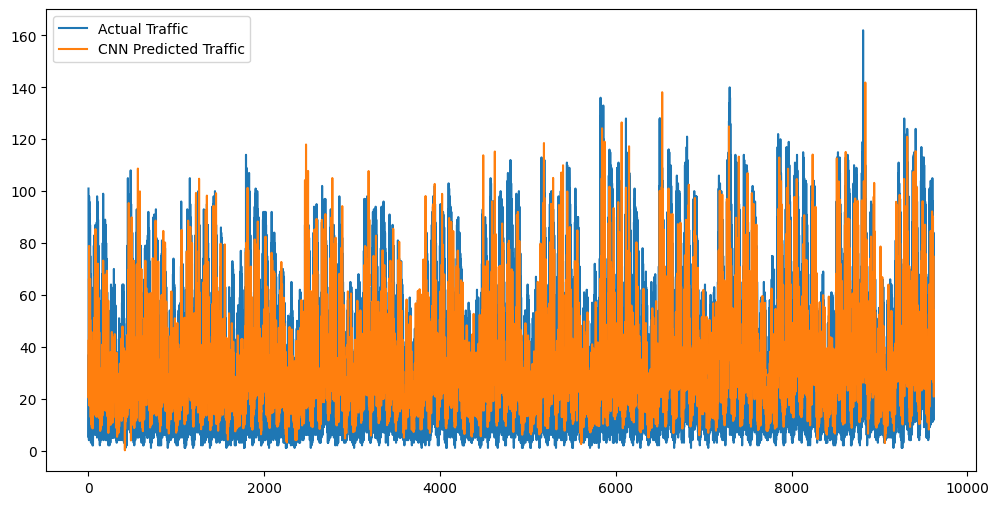

In [32]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Traffic")
plt.plot(pred_cnn, label="CNN Predicted Traffic")
plt.legend()
plt.show()


In [33]:
for i in range(10):
    print(f"Actual: {y_test_actual[i][0]:.2f} | CNN Predicted: {pred_cnn[i][0]:.2f}")


Actual: 101.00 | CNN Predicted: 42.31
Actual: 40.00 | CNN Predicted: 20.31
Actual: 5.00 | CNN Predicted: 27.14
Actual: 22.00 | CNN Predicted: 28.08
Actual: 37.00 | CNN Predicted: 36.99
Actual: 4.00 | CNN Predicted: 66.23
Actual: 30.00 | CNN Predicted: 61.36
Actual: 98.00 | CNN Predicted: 78.87
Actual: 23.00 | CNN Predicted: 47.72
Actual: 96.00 | CNN Predicted: 35.83


In [34]:
mae_cnn = mean_absolute_error(y_test_actual, pred_cnn)
rmse_cnn = np.sqrt(mean_squared_error(y_test_actual, pred_cnn))

print("CNN MAE:", mae_cnn)
print("CNN RMSE:", rmse_cnn)


CNN MAE: 18.442125818852855
CNN RMSE: 23.88637413060035


In [37]:
# encoder decoder

def create_sequences_multi(data, time_steps=24, future_steps=3):
    X, y = [], []
    
    for i in range(len(data) - time_steps - future_steps):
        X.append(data[i:i+time_steps])  # past 24 hours
        y.append(data[i+time_steps:i+time_steps+future_steps, -1])  
        # next 3 vehicle values
    
    return np.array(X), np.array(y)

future_steps = 3
X_seq, y_seq = create_sequences_multi(scaled_data, 24, future_steps)

print("X shape:", X_seq.shape)  # (samples, 24, features)
print("y shape:", y_seq.shape)  # (samples, 3)


X shape: (48093, 24, 6)
y shape: (48093, 3)


In [38]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [39]:
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential

model_seq2seq = Sequential()

# 🔹 Encoder
model_seq2seq.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
# Learns full past history

# 🔹 Repeat context for each future step
model_seq2seq.add(RepeatVector(future_steps))

# 🔹 Decoder
model_seq2seq.add(LSTM(64, return_sequences=True))

# 🔹 Output for each time step
model_seq2seq.add(TimeDistributed(Dense(1)))

model_seq2seq.compile(optimizer='adam', loss='mse')
model_seq2seq.summary()


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 1)           │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,265 (200.25 KB)

 Trainable params: 51,265 (200.25 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history_seq = model_seq2seq.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - loss: 0.0084 - val_loss: 0.0190
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - loss: 0.0079 - val_loss: 0.0187
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 0.0078 - val_loss: 0.0186
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 0.0077 - val_loss: 0.0189
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0077 - val_loss: 0.0184
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0076 - val_loss: 0.0183
Epoch 7/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - loss: 0.0076 - val_loss: 0.0189
Epoch 8/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - loss: 0.0075 - val_loss: 0.0182
Epoch 9/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0075 - val_loss: 0.0193
Epoch 10/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0075 - val_loss: 0.0184
Epoch 11/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - loss: 0.0074 - val_loss: 0.0186
Epoch 12

In [41]:
pred_seq = model_seq2seq.predict(X_test)


301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [42]:
pred_seq_reshaped = pred_seq.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)

pred_seq_real = vehicles_scaler.inverse_transform(pred_seq_reshaped)
y_test_real = vehicles_scaler.inverse_transform(y_test_reshaped)

pred_seq_real = pred_seq_real.reshape(-1, future_steps)
y_test_real = y_test_real.reshape(-1, future_steps)


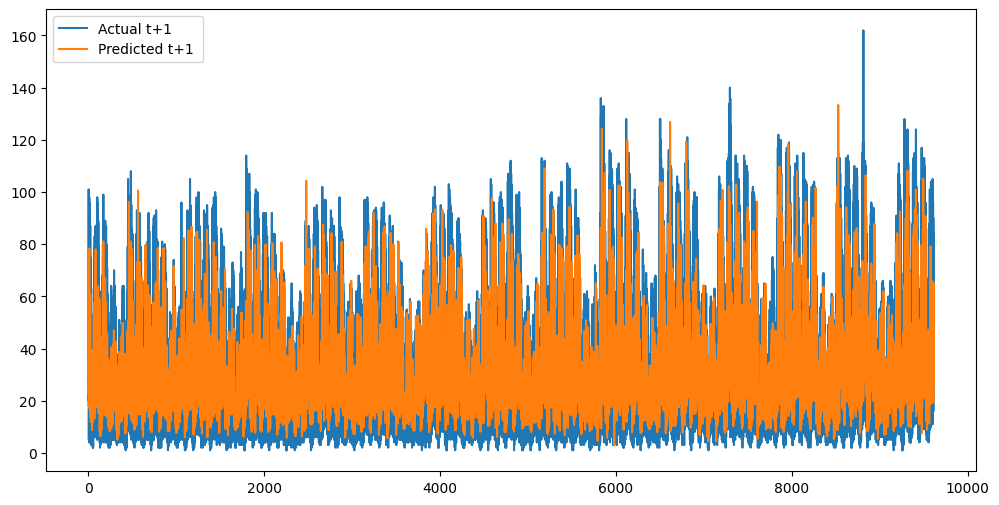

In [47]:
plt.figure(figsize=(12,6))
plt.plot(y_test_real[:,0], label="Actual t+1 ")
plt.plot(pred_seq_real[:,0], label="Predicted t+1 ")
plt.legend()
plt.show()


In [45]:
for i in range(5):
    print(f"\nSample {i+1}")
    for step in range(future_steps):
        print(f"  t+{step+1} → Actual: {y_test_real[i][step]:.2f} | Predicted: {pred_seq_real[i][step]:.2f}")



Sample 1
  t+1 → Actual: 30.00 | Predicted: 22.92
  t+2 → Actual: 20.00 | Predicted: 28.67
  t+3 → Actual: 101.00 | Predicted: 32.48

Sample 2
  t+1 → Actual: 20.00 | Predicted: 26.95
  t+2 → Actual: 101.00 | Predicted: 30.99
  t+3 → Actual: 40.00 | Predicted: 34.13

Sample 3
  t+1 → Actual: 101.00 | Predicted: 36.35
  t+2 → Actual: 40.00 | Predicted: 40.98
  t+3 → Actual: 5.00 | Predicted: 36.25

Sample 4
  t+1 → Actual: 40.00 | Predicted: 18.02
  t+2 → Actual: 5.00 | Predicted: 20.20
  t+3 → Actual: 22.00 | Predicted: 27.32

Sample 5
  t+1 → Actual: 5.00 | Predicted: 20.75
  t+2 → Actual: 22.00 | Predicted: 24.98
  t+3 → Actual: 37.00 | Predicted: 38.18


In [46]:


for step in range(future_steps):
    mae = mean_absolute_error(y_test_real[:,step], pred_seq_real[:,step])
    rmse = np.sqrt(mean_squared_error(y_test_real[:,step], pred_seq_real[:,step]))
    
    print(f"Step t+{step+1} → MAE: {mae:.2f} | RMSE: {rmse:.2f}")


Step t+1 → MAE: 16.14 | RMSE: 22.16
Step t+2 → MAE: 19.20 | RMSE: 24.75
Step t+3 → MAE: 19.62 | RMSE: 25.46


In [48]:

# transformer
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model


In [49]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# 🔹 Self-Attention
attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
attn_output = LayerNormalization(epsilon=1e-6)(attn_output)

# 🔹 Feed Forward Network
ffn = Dense(64, activation='relu')(attn_output)
ffn = Dense(32, activation='relu')(ffn)

# 🔹 Pooling to reduce sequence → vector
pooled = GlobalAveragePooling1D()(ffn)

# 🔹 Output layer
outputs = Dense(1)(pooled)

model_transformer = Model(inputs, outputs)

model_transformer.compile(optimizer='adam', loss='mse')
model_transformer.summary()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 6)     │      1,734 │ input_layer_5[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 6)     │         12 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 24, 64)    │        448 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 24, 32)    │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ dense_7[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,307 (16.82 KB)

 Trainable params: 4,307 (16.82 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history_tr = model_transformer.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0092 - val_loss: 0.0205
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0085 - val_loss: 0.0202
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0084 - val_loss: 0.0203
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0083 - val_loss: 0.0199
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0082 - val_loss: 0.0198
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 0.0081 - val_loss: 0.0195
Epoch 7/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - loss: 0.0080 - val_loss: 0.0192
Epoch 8/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0080 - val_loss: 0.0193
Epoch 9/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0080 - val_loss: 0.0191
Epoch 10/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0080 - val_loss: 0.0192
Epoch 11/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0080 - val_loss: 0.0190
Epoch 12

In [51]:
pred_tr = model_transformer.predict(X_test)
pred_tr = vehicles_scaler.inverse_transform(pred_tr)


301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


In [52]:
for i in range(10):
    print(f"Actual: {y_test_actual[i][0]:.2f} | Transformer Predicted: {pred_tr[i][0]:.2f}")


Actual: 101.00 | Transformer Predicted: 27.54
Actual: 40.00 | Transformer Predicted: 32.37
Actual: 5.00 | Transformer Predicted: 37.20
Actual: 22.00 | Transformer Predicted: 24.95
Actual: 37.00 | Transformer Predicted: 30.09
Actual: 4.00 | Transformer Predicted: 33.73
Actual: 30.00 | Transformer Predicted: 38.26
Actual: 98.00 | Transformer Predicted: 43.98
Actual: 23.00 | Transformer Predicted: 47.92
Actual: 96.00 | Transformer Predicted: 52.17


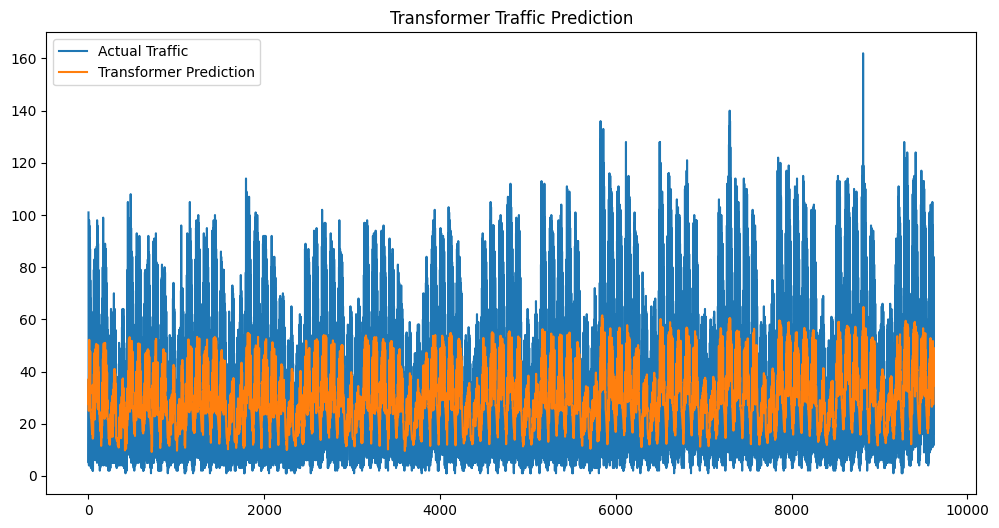

In [53]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Traffic")
plt.plot(pred_tr, label="Transformer Prediction")
plt.legend()
plt.title("Transformer Traffic Prediction")
plt.show()


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_tr = mean_absolute_error(y_test_actual, pred_tr)
rmse_tr = np.sqrt(mean_squared_error(y_test_actual, pred_tr))

print("Transformer MAE:", mae_tr)
print("Transformer RMSE:", rmse_tr)

ValueError: Found input variables with inconsistent numbers of samples: [9620, 9619]